In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cmocean.cm as cmo
import sys
sys.path.append("FNO/ResNet/")
from utilities3 import *
import scipy.stats
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from cycler import cycler

fh = 16
my_cycler = (cycler(color=['#94c8d8','#FE9A84','#296540','#E63F39','#C3AAD1',
              '#D5AC5A','#F4B6C3','#B4BCCA','#DBD468','#B1D3E1','#8b1821']))
plt.rcParams['figure.figsize'] = (18,12)
plt.rcParams['axes.prop_cycle'] = my_cycler
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = fh
plt.rcParams['xtick.labelsize'] = fh
plt.rcParams['ytick.labelsize'] = fh
plt.rcParams['axes.titlesize'] = fh+2

# plot

In [4]:
res = 128
var = 'vapor'
data = {}
methods = ['ResNet','FNO']

for m in methods:
    data_path = f'../alpha/2023_05_22/tests/{method}_out_{var}_r_{res}.npy'
    data[m] = np.load(data_path)[0]

(2, 1000, 1, 128, 128)


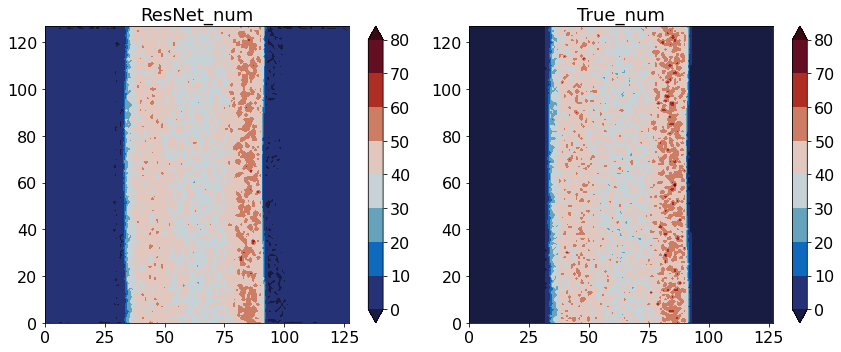

In [26]:
res = 128
var = 'vapor'
#var = 'supersat'
var = 'num'
method = 'ResNet'
data_path = f'../alpha/2023_05_22/tests/{method}_out_{var}_r_{res}.npy'
data = np.load(data_path)
print(data.shape)
pred = data[0,300,0,:,:]
true = data[1,300,0,:,:]
ii = np.arange(res)

cranges = {}
cranges['supersat'] = np.arange(-0.32,-0.2561,0.008)
cranges['vapor'] = np.arange(2.625,2.851,0.025)
cranges['num'] = np.arange(0,80.1,10)

cranges1 = {}
cranges1['vapor'] = np.arange(1.5,14.0,1.5)
cranges1['supersat'] = np.arange(6,48.1,6)
cranges1['num'] = np.arange(0,0.08,0.005)

fig,axes = plt.subplots(1,2,figsize=(12,5))
a1 = axes[0].contourf(ii,ii,pred,cranges[var],extend='both',cmap=cmo.balance)
a2 = axes[1].contourf(ii,ii,true,cranges[var],extend='both',cmap=cmo.balance)

#a1 = axes[0].contourf(ii,ii,pred)
#a2 = axes[1].contourf(ii,ii,true)

fig.colorbar(a1,ax=axes[0])
fig.colorbar(a2,ax=axes[1])

axes[0].set_title(f'{method}_{var}')
axes[1].set_title(f'True_{var}')

plt.tight_layout()

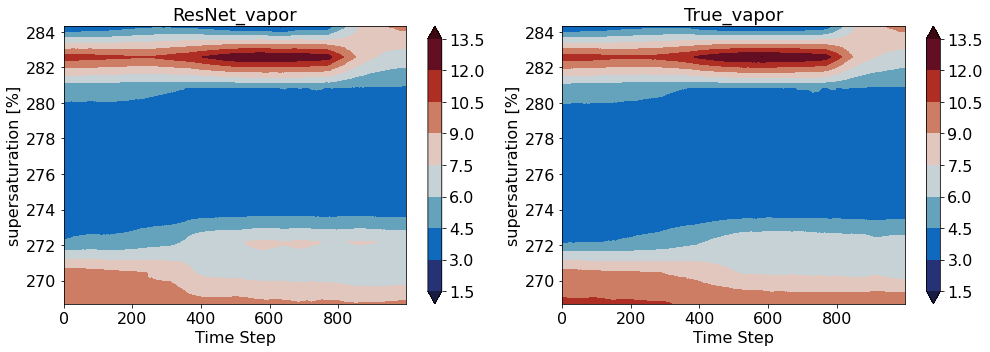

In [23]:
nbins = 10
pred_hist = np.zeros((data.shape[1],nbins))
true_hist = np.zeros((data.shape[1],nbins))

for i in range(len(pred_hist)):
    pred_hist[i,:],bin_edges = np.histogram(data[0,i,0,:,:],bins=nbins,density=True)
    true_hist[i,:],_ = np.histogram(data[1,i,0,:,:],bins=nbins,density=True)

ii = np.arange(data.shape[1])
jj = np.arange(nbins)

fig, axes = plt.subplots(1,2,figsize=(14,5))
a1 = axes[0].contourf(ii,bin_edges[1:]*100,pred_hist.T,cranges1[var],extend='both',cmap=cmo.balance)
a2 = axes[1].contourf(ii,bin_edges[1:]*100,true_hist.T,cranges1[var],extend='both',cmap=cmo.balance)

#a1 = axes[0].contourf(ii,bin_edges[1:],pred_hist.T)
#a2 = axes[1].contourf(ii,bin_edges[1:],true_hist.T)

fig.colorbar(a1,ax=axes[0])
fig.colorbar(a2,ax=axes[1])

axes[0].set_title(f'{method}_{var}')
axes[1].set_title(f'True_{var}')

axes[0].set_xlabel('Time Step')
axes[1].set_xlabel('Time Step')

#axes[0].set_ylabel('vapor mixing ratio [g/kg]')
#axes[1].set_ylabel('vapor mixing ratio [g/kg]')

axes[0].set_ylabel('supersaturation [%]')
axes[1].set_ylabel('supersaturation [%]')

plt.tight_layout()

plt.savefig(f'figs/{var}_pdf.pdf')

# train perf

In [ ]:
def eval_loss(log_name):
    log1 = pd.read_csv(log_name,sep='\s+',header=None)
    train_loss =  np.array([float(i.split('=')[1]) for i in log1[8].values])
    test_loss = np.array([float(i.split('=')[1]) for i in log1[9].values])
    
    return train_loss, test_loss

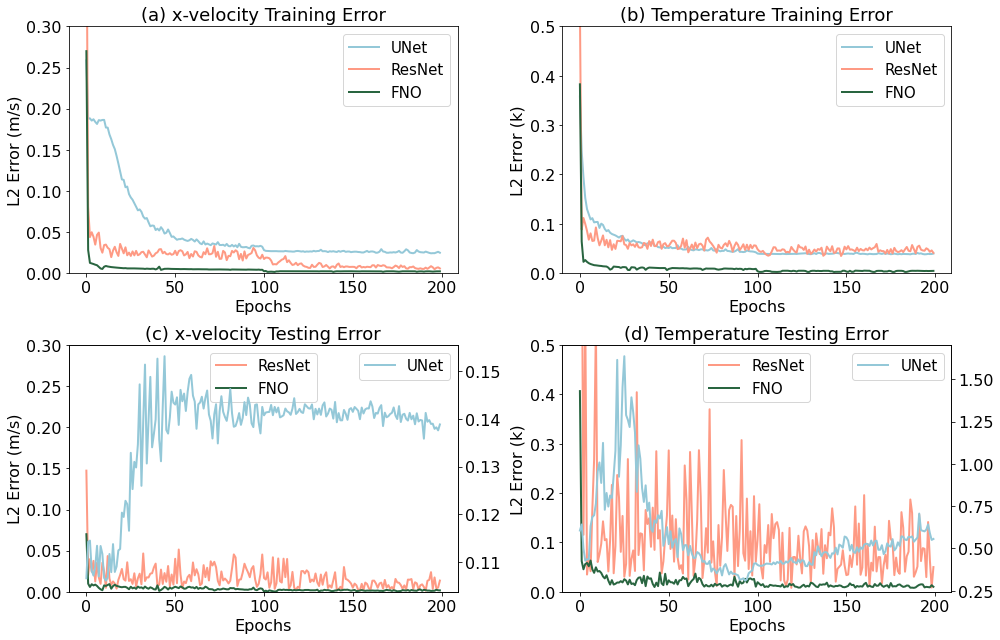

In [15]:
fig, axes = plt.subplots(2,2,figsize=(14,9))

varns = ['xvel','temp']
varn_full = ['x-velocity','Temperature']
models = ['UNet','ResNet','FNO']
ylabels = ['L2 Error (m/s)','L2 Error (k)']
ylims = [[0,0.3],[0.0,0.5]]
index = ['(a)', '(b)', '(c)', '(d)']
colors = ['#94c8d8','#FE9A84','#296540']


for i,vn in enumerate(varns):
    for k,m in enumerate(models):
        #train_loss, test_loss = eval_loss(f'archived/20230410_v1//logs/archive/{m}_log_{vn}_r_256')
        train_loss, test_loss = eval_loss(f'archived/20230410_v1//logs/archive/{m}_log_{vn}_r_64')
        
        for jj,value in enumerate(train_loss):
            if value > 10:
                train_loss[jj] = train_loss[jj-1]
        
        axes[0][i].plot(train_loss[:200], label=m)
        if m != 'UNet':
            axes[1][i].plot(test_loss[:200], label=m, color=colors[k])
        else:
            ax2 = axes[1][i].twinx()
            ax2.plot(test_loss[:200], color='#94c8d8',label=m)
            ax2.legend()
    
        #axes[i].plot(test_loss[:200],label=m,linestyle='dashed')
        
    axes[0][i].set_ylim(ylims[i])
    axes[0][i].set_xlabel("Epochs")
    axes[0][i].set_ylabel(ylabels[i])
    axes[0][i].legend()
    axes[0][i].set_title(f'{index[i]} {varn_full[i]} Training Error')
    
    axes[1][i].set_ylim(ylims[i])
    axes[1][i].set_xlabel("Epochs")
    axes[1][i].set_ylabel(ylabels[i])
    axes[1][i].legend(loc='upper center')
    axes[1][i].set_title(f'{index[2+i]} {varn_full[i]} Testing Error')

plt.tight_layout()
plt.savefig(f'figs/train_log.pdf')

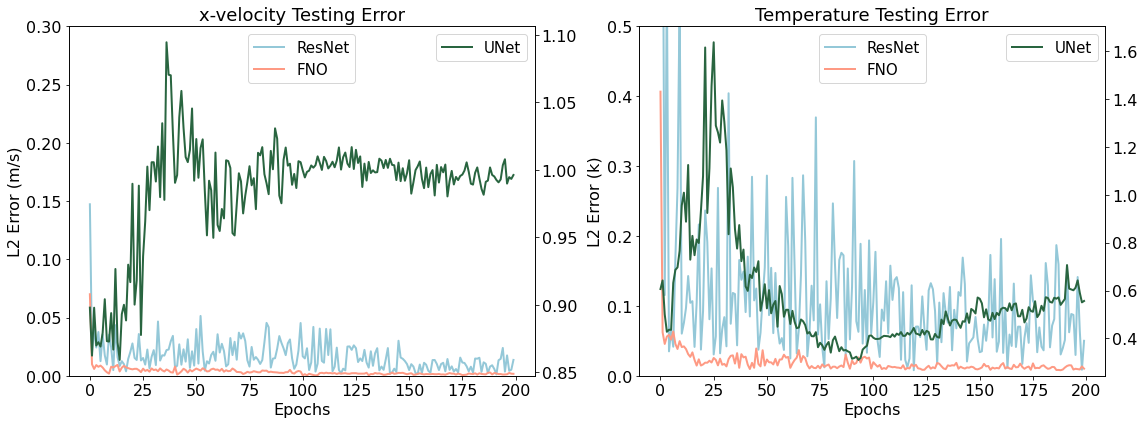

In [128]:
fig, axes = plt.subplots(1,2,figsize=(16,6))

varns = ['xvel','temp']
varn_full = ['x-velocity','Temperature']
models = ['ResNet','FNO','UNet']
ylabels = ['L2 Error (m/s)','L2 Error (k)']
ylims = [[0,0.3],[0.0,0.5]]
for i,vn in enumerate(varns):
    for m in models:
        train_loss, test_loss = eval_loss(f'logs/archive/{m}_log_{vn}_r_64')
        
        for jj,value in enumerate(train_loss):
            if value > 10:
                train_loss[jj] = train_loss[jj-1]
        if m != 'UNet':
            axes[i].plot(test_loss[:200], label=m)
        else:
            ax2 = axes[i].twinx()
            ax2.plot(test_loss[:200], color='#296540',label=m)
            ax2.legend()
        
    axes[i].set_ylim(ylims[i])
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(ylabels[i])
    axes[i].legend(loc='upper center')
    axes[i].set_title(f'{varn_full[i]} Testing Error')
    
plt.tight_layout()
plt.savefig(f'figs/test_log.pdf')

## test perf

# test perf

In [38]:
train_loss, test_loss = eval_loss(f'../logs/archive/FNO_log__r_128')

UNet_64:0.99676
UNet_128:0.05755
UNet_256:0.07836
ResNet_64:0.00098
ResNet_128:0.00089
ResNet_256:0.0033
FNO_64:0.00012
FNO_128:0.00012
FNO_256:0.00065
UNet_64:0.72196
UNet_128:1.03564
UNet_256:3.60284
ResNet_64:0.0243
ResNet_128:0.39108
ResNet_256:0.04297
FNO_64:0.0079
FNO_128:0.01307
FNO_256:0.19605


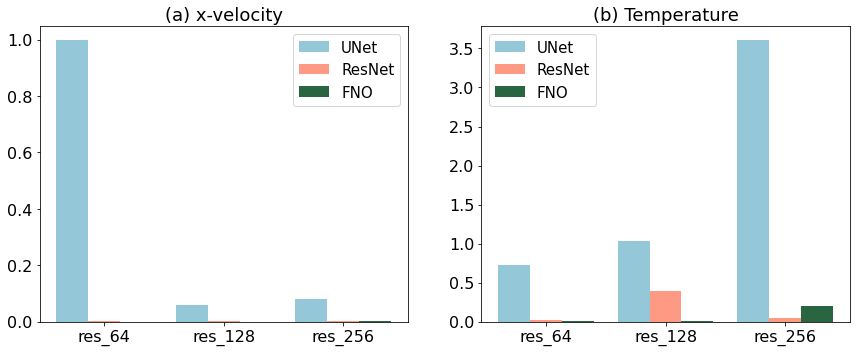

In [30]:
varns = ['xvel','num','temp']
models = ['UNet','ResNet','FNO']
#models = ['UNet','FNO']
res = ['64','128','256']
index = ['(a)','(b)']

fig,axes = plt.subplots(1,2,figsize=(12,5))
x = np.arange(len(res))
y = np.arange(len(res))
TW = 0.8
W = TW/len(models)
x = x - (TW - W)/2

for k,v in enumerate(['xvel','temp']):
    data = np.zeros([len(models),len(res)])
    for i,m in enumerate(models):
        for j,r in enumerate(res):
            train_loss, test_loss = eval_loss(f'logs/archive/{m}_log_{v}_r_{r}')
            print(f'{m}_{r}:{test_loss[-1]}')
            data[i,j] = test_loss[-1]
        
    for i,m in enumerate(models):
        axes[k].bar(x+i*W,data[i,:],width=W,label=m)
    
    axes[k].set_xticks(y,[f'res_{i}' for i in res])
    axes[k].legend()
    axes[k].set_title(index[k]+" "+varn_full[k])
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig('figs/resolution_perf.pdf')

## time perf

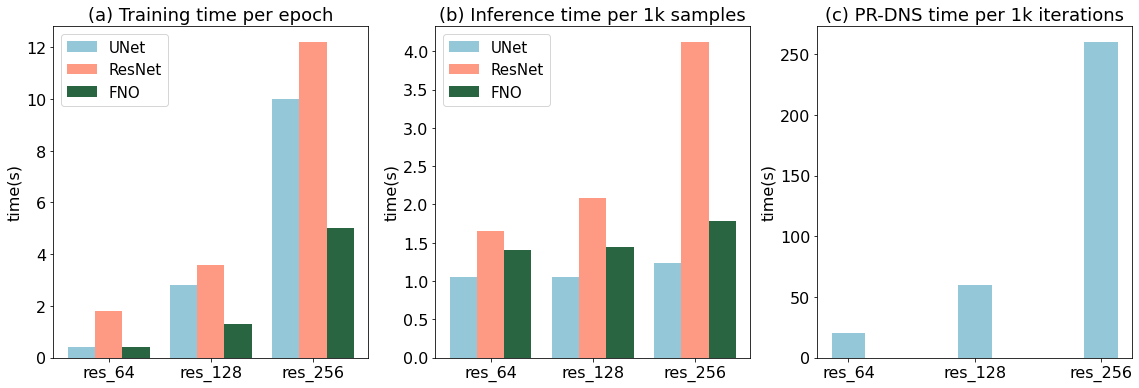

In [14]:
train_data = np.array([[0.4,2.8,10], #UNet
                 [1.8,3.6,12.2], #ResNet
                 [0.4,1.3,5], #FNO
])

test_data = np.array([[1.05,1.05,1.23], #UNet
                      [1.66,2.08,4.12], #ResNet
                      [1.4,1.45,1.78], #FNO
])

dns_data = np.array([20,60,260])

res = ['64','128','256']

fig,axes = plt.subplots(1,3,figsize=(16,5.5))
x = np.arange(len(res))
y = np.arange(len(res))
TW = 0.8
W = TW/len(models)
x = x - (TW - W)/2

for i,m in enumerate(models):
    axes[0].bar(x+i*W,train_data[i,:],width=W,label=m)
    axes[1].bar(x+i*W,test_data[i,:],width=W,label=m)

axes[2].bar(y,dns_data,width=W)
    
axes[0].legend()
axes[0].set_xticks(y,[f'res_{i}' for i in res])
axes[0].set_ylabel('time(s)')
axes[0].set_title('(a) Training time per epoch')

axes[1].legend()
axes[1].set_xticks(y,[f'res_{i}' for i in res])
axes[1].set_ylabel('time(s)')
axes[1].set_title('(b) Inference time per 1k samples')

axes[2].set_xticks(y,[f'res_{i}' for i in res])
axes[2].set_ylabel('time(s)')
axes[2].set_title('(c) PR-DNS time per 1k iterations')

plt.tight_layout()
plt.savefig('figs/time.pdf')

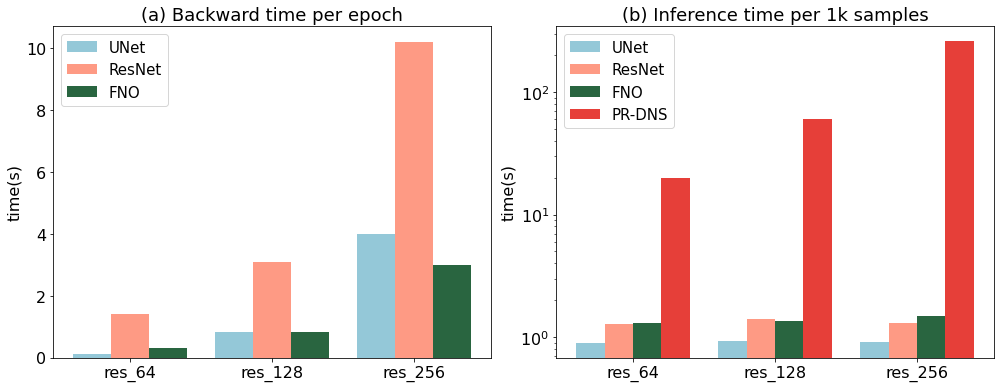

In [54]:
train_data = np.array([[0.4,2.8,10], #UNet
                 [1.8,3.6,12.2], #ResNet
                 [0.4,1.3,5], #FNO
])

train_data = np.array([[0.13,0.83,4], #UNet
                 [1.41,3.1,10.2], #ResNet
                 [0.31,0.84,2.99], #FNO
])

test_data = np.array([[1.05,1.05,1.23], #UNet
                      [1.66,2.08,4.12], #ResNet
                      [1.4,1.45,1.78], #FNO
                      [20,60,260]  # PR-DNS
])


test_data = np.array([[0.9,0.92,0.91], #UNet
                      [1.28,1.4,1.29], #ResNet
                      [1.31,1.34,1.47], #FNO
                      [20,60,260]  # PR-DNS
])

dns_data = np.array([20,60,260])

res = ['64','128','256']

fig,axes = plt.subplots(1,2,figsize=(14,5.5))
x0 = np.arange(len(res))
y = np.arange(len(res))
TW = 0.8
W = TW/len(models)
x = x0 - (TW - W)/2

TW = 0.8
W1 = TW/4
x1 = x0 - (TW - W1)/2

for i,m in enumerate(models):
    axes[0].bar(x+i*W,train_data[i,:],width=W,label=m)
    axes[1].bar(x1+i*W1,test_data[i,:],width=W1,label=m)

#axes[2].bar(y,dns_data,width=W)
#ax_twin = axes[1].twinx()
axes[1].bar(x1+3*W1, test_data[3,:],width=W1,label='PR-DNS')
    
axes[0].legend()
axes[0].set_xticks(y,[f'res_{i}' for i in res])
axes[0].set_ylabel('time(s)')
axes[0].set_title('(a) Backward time per epoch')

#axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_xticks(y,[f'res_{i}' for i in res])
axes[1].set_ylabel('time(s)')
axes[1].set_title('(b) Inference time per 1k samples')


#axes[2].set_xticks(y,[f'res_{i}' for i in res])
#axes[2].set_ylabel('time(s)')
#axes[2].set_title('(c) PR-DNS time per 1k iterations')

plt.tight_layout()
plt.savefig('figs/time.pdf')

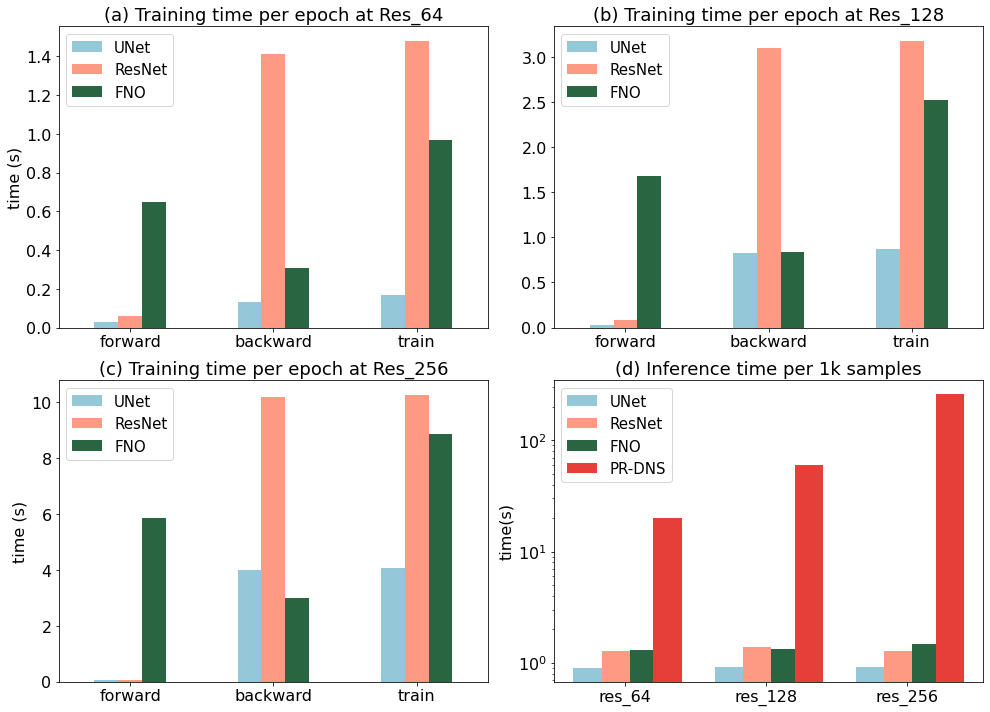

In [50]:
fig,axes = plt.subplots(2,2,figsize=(14,10))

test_data = np.array([[0.9,0.92,0.91], #UNet
                      [1.28,1.4,1.29], #ResNet
                      [1.31,1.34,1.47], #FNO
                      [20,60,260]  # PR-DNS
])

idd = ['(a)','(b)','(c)']

for i,r in enumerate([64,128,256]):
    data = pd.read_excel('PR_DNS_performance.xlsx', sheet_name=f'ML_train_r{r}')
    data = data.set_index('process')

    title = f'{idd[i]} Training time per epoch at Res_{r}'
    if i % 2 == 0:
        ylabel = 'time (s)'
    else:
        ylabel = ''
    data.plot.bar(rot=0,ax=axes[i//2][i%2],xlabel='',ylabel=ylabel,title=title)

res = [64,128,256]
x0 = np.arange(len(res))
y = np.arange(len(res))
TW = 0.8
W = TW/len(models)
x = x0 - (TW - W)/2

TW = 0.8
W1 = TW/4
x1 = x0 - (TW - W1)/2

for i,m in enumerate(models):
    axes[1][1].bar(x+i*W1,test_data[i,:],width=W1,label=m)
axes[1][1].bar(x1+3*W1, test_data[3,:],width=W1,label='PR-DNS')

axes[1][1].set_yscale('log')
axes[1][1].legend()
axes[1][1].set_xticks(y,[f'res_{i}' for i in res])
axes[1][1].set_ylabel('time(s)')
axes[1][1].set_title('(d) Inference time per 1k samples')

plt.tight_layout()
plt.savefig('figs/time.pdf')

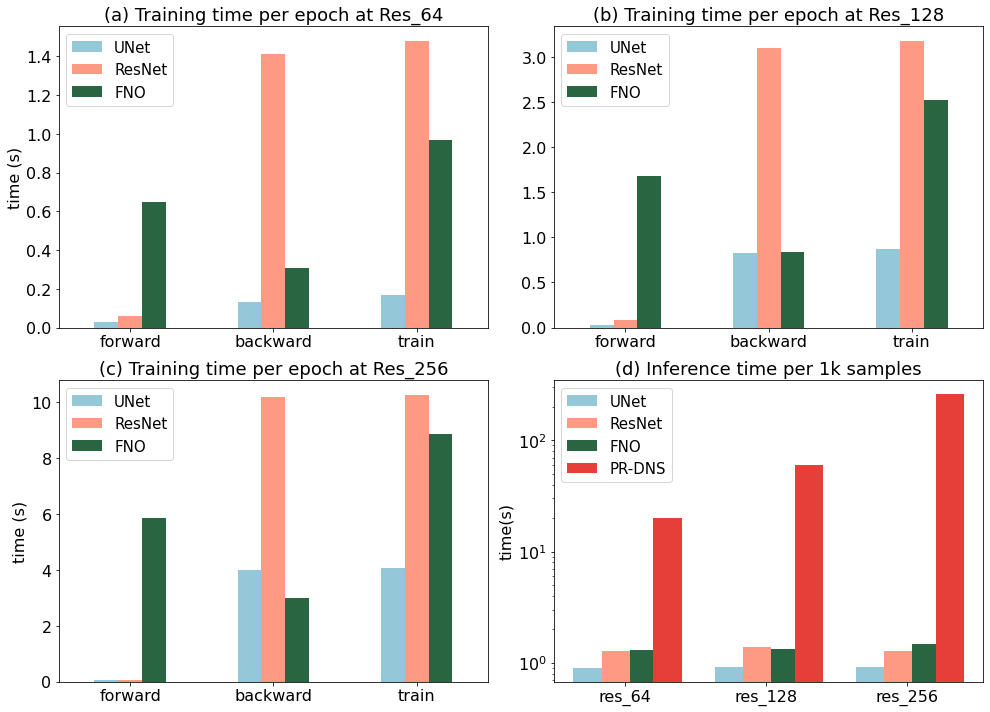

In [51]:
fig,axes = plt.subplots(2,2,figsize=(14,10))

test_data = np.array([[0.9,0.92,0.91], #UNet
                      [1.28,1.4,1.29], #ResNet
                      [1.31,1.34,1.47], #FNO
                      [20,60,260]  # PR-DNS
])

idd = ['(a)','(b)','(c)']

for i,r in enumerate([64,128,256]):
    data = pd.read_excel('PR_DNS_performance.xlsx', sheet_name=f'ML_train_r{r}')
    data = data.set_index('process')

    title = f'{idd[i]} Training time per epoch at Res_{r}'
    if i % 2 == 0:
        ylabel = 'time (s)'
    else:
        ylabel = ''
    data.plot.bar(rot=0,ax=axes[i//2][i%2],xlabel='',ylabel=ylabel,title=title)

res = [64,128,256]
x0 = np.arange(len(res))
y = np.arange(len(res))
TW = 0.8
W = TW/len(models)
x = x0 - (TW - W)/2

TW = 0.8
W1 = TW/4
x1 = x0 - (TW - W1)/2

for i,m in enumerate(models):
    axes[1][1].bar(x+i*W1,test_data[i,:],width=W1,label=m)
axes[1][1].bar(x1+3*W1, test_data[3,:],width=W1,label='PR-DNS')

axes[1][1].set_yscale('log')
axes[1][1].legend()
axes[1][1].set_xticks(y,[f'res_{i}' for i in res])
axes[1][1].set_ylabel('time(s)')
axes[1][1].set_title('(d) Inference time per 1k samples')

plt.tight_layout()
plt.savefig('figs/time.pdf')

## data

In [262]:
def norm_2(data1, data2):
    # data2 is true
    l2 = 0
    l2_mean = 0
    for i in range(len(data1)):
        l2 += (data1[i] - data2[i])**2
        l2_mean += data2[i] ** 2
    
    l2 = l2 ** 0.5
    
    l2_mean = l2_mean ** 0.5
    
    return l2/l2_mean

In [486]:
res = 128
var = 'temp'
models = ['UNet','ResNet','FNO']
outs = {}

units = {}
units['temp'] = 'k'
units['xvel'] = 'm/s'
units['num'] = ''

for m in models:
    outs[m] = np.load(f'tests/{m}_out_{var}_r_{res}.npy')[0,:,0,:,:]

outs['True'] = np.load(f'tests/UNet_out_{var}_r_{res}.npy')[1,:,0,:,:] 

print(outs['True'].shape)

# correlation
corrs = {}

for m in models:
    tmp = np.zeros((res,res))
    for i in range(res):
        for j in range(res):
            #if m == 'UNet':
            #tmp[i,j] = scipy.stats.pearsonr(outs[m][:,i,j],outs['True'][:,i,j])[0]
            tmp[i,j] = norm_2(outs[m][:,i,j],outs['True'][:,i,j])
            #else:
            #    tmp[i,j] = mean_absolute_percentage_error(outs['True'][:,i,j],outs[m][:,i,j])
    corrs[m] = tmp * 100

(1000, 128, 128)


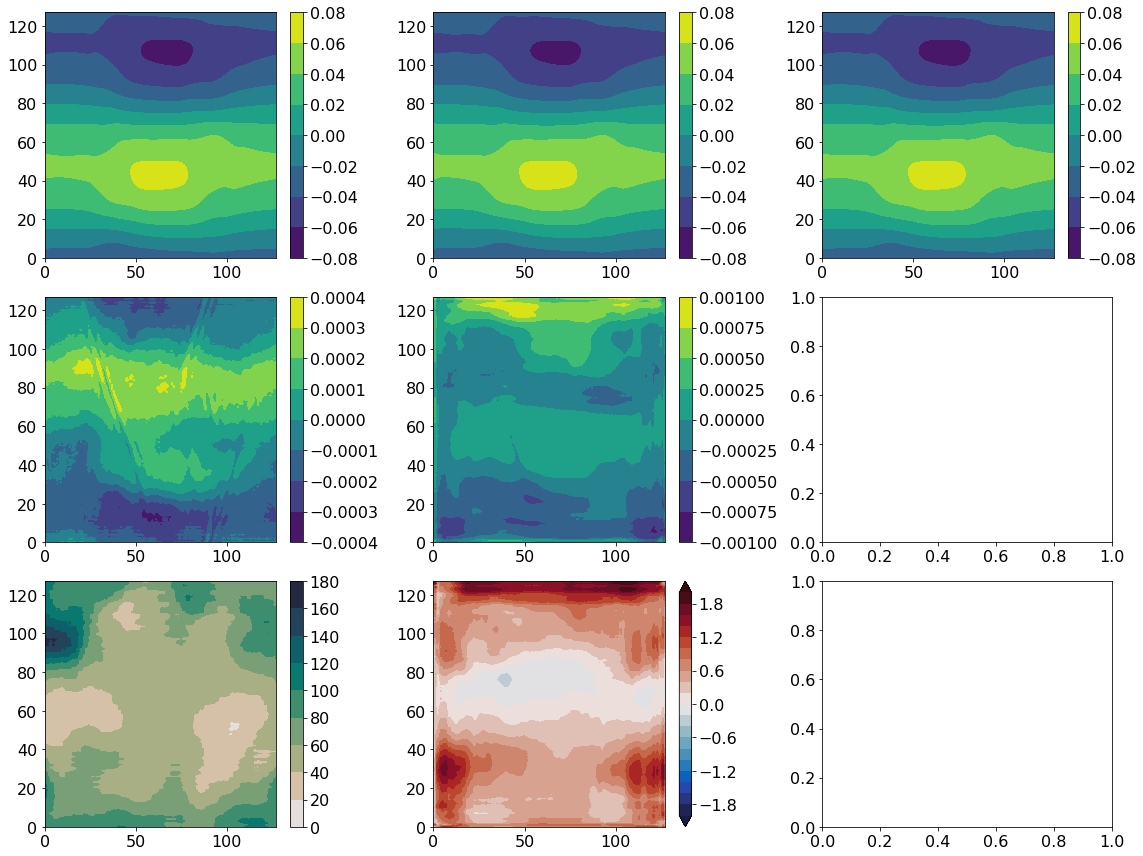

In [339]:
ii = np.arange(res)
jj = np.arange(res)

cr = np.arange(-2,2.01,0.2)

fig, axes = plt.subplots(3,3,figsize=(16,12))

fno = outs['FNO'][500,:,:]
resnet = outs['ResNet'][500,:,:]
true = outs['True'][500,:,:]

p1 = axes[0][0].contourf(ii,jj,fno)
p2 = axes[0][1].contourf(ii,jj,resnet)
p3 = axes[0][2].contourf(ii,jj,true)

p4 = axes[1][0].contourf(ii,jj,fno - true)
p5 = axes[1][1].contourf(ii,jj,resnet - true)

p6 = axes[2][0].contourf(ii,jj,corrs['UNet']-corrs['FNO'],cmap=cmo.rain)
p7 = axes[2][1].contourf(ii,jj,corrs['ResNet']-corrs['FNO'],cr,extend='both',cmap=cmo.balance)

fig.colorbar(p1,ax=axes[0][0])
fig.colorbar(p2,ax=axes[0][1])
fig.colorbar(p3,ax=axes[0][2])
fig.colorbar(p4,ax=axes[1][0])
fig.colorbar(p5,ax=axes[1][1])
fig.colorbar(p6,ax=axes[2][0])
fig.colorbar(p7,ax=axes[2][1])



plt.tight_layout()

## testing

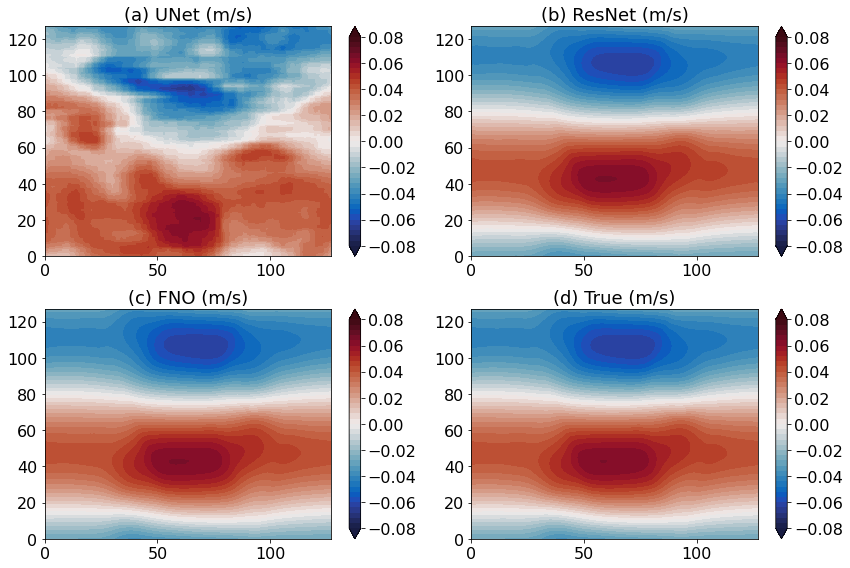

In [373]:
cranges = {}
#cranges['xvel'] = np.arange(-0.032,0.0322,0.002)
cranges['xvel'] = np.arange(-0.08,0.0801,0.004)
cranges['num'] = np.arange(0,240,10)
cranges['temp'] = np.arange(270.4,271,0.025)


ii = np.arange(res)
jj = np.arange(res)
index = ['(a)','(b)','(c)','(d)']

fig, axes = plt.subplots(2,2,figsize=(12,8))

for i,m in enumerate(outs):
    a = axes[i//2][i%2].contourf(ii, jj, outs[m][500,:,:],cranges[var],extend='both',cmap=cmo.balance)
    fig.colorbar(a,ax=axes[i//2][i%2])
    axes[i//2][i%2].set_title(f'{index[i]} {m} ({units[var]})')
    
plt.tight_layout()
plt.savefig(f'figs/{var}_2d.pdf')

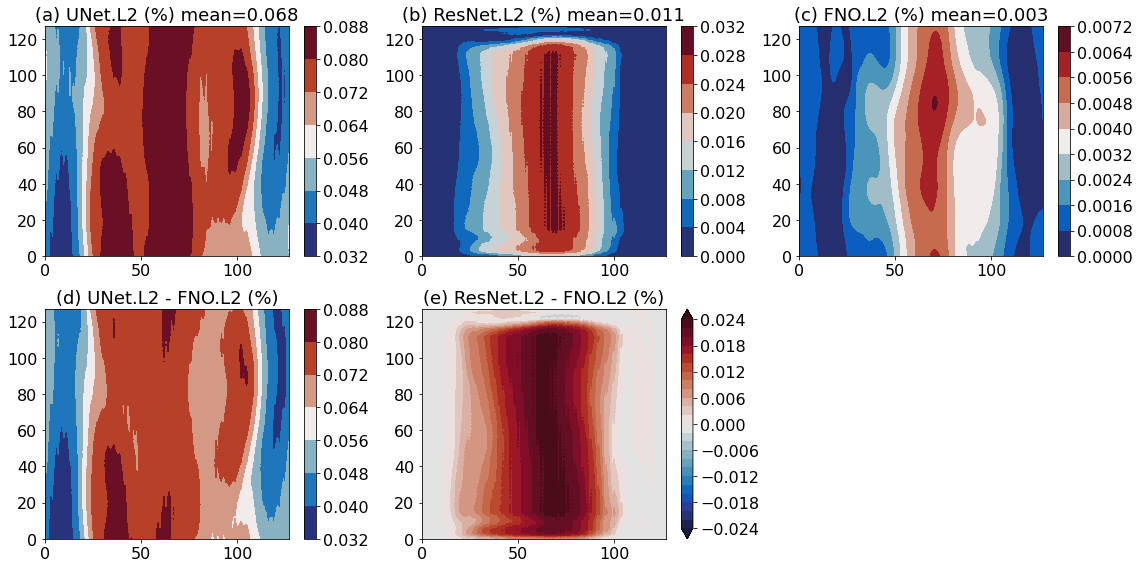

In [488]:
cranges = {}
#cranges['xvel'] = np.arange(-0.032,0.0322,0.002)
cranges['xvel'] = np.arange(0,1.5,0.1)
cranges['num'] = np.arange(0,240,10)
cranges['temp'] = np.arange(270.4,271,0.025)


ii = np.arange(res)
jj = np.arange(res)
index = ['(a)','(b)','(c)']

fig, axes = plt.subplots(2,3,figsize=(16,8))

for i,m in enumerate(models):
    mean_value = np.mean(corrs[m])
    #if m == 'UNet':
    a = axes[0][i].contourf(ii,jj, corrs[m],cmap=cmo.balance)
    #else:
    #    a = axes[0][i].contourf(ii,jj, corrs[m],cranges[var],extend='both',cmap=cmo.balance)
    fig.colorbar(a,ax=axes[0][i])
    axes[0][i].set_title(f'{index[i]} {m}.L2 (%) mean={mean_value:.3f}')


a = axes[1][0].contourf(ii,jj,corrs['UNet'] - corrs['FNO'],cmap=cmo.balance)
fig.colorbar(a,ax=axes[1][0])
axes[1][0].set_title(f'(d) UNet.L2 - FNO.L2 (%)')

cr = np.arange(-0.024,0.0241,0.002)
#cr = np.arange(-2,2.01,0.2)
a = axes[1][1].contourf(ii,jj,corrs['ResNet'] - corrs['FNO'],cr,extend='both',cmap=cmo.balance)
fig.colorbar(a,ax=axes[1][1])
axes[1][1].set_title(f'(e) ResNet.L2 - FNO.L2 (%)')

axes[1][2].axis('off')
    
plt.tight_layout()
plt.savefig(f'figs/{var}_2d_loss.pdf')

## super resolution

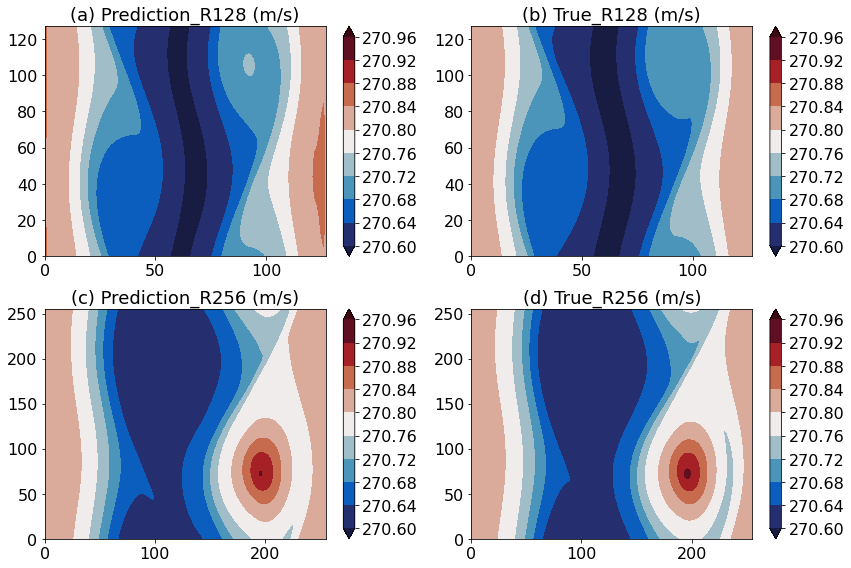

In [94]:
ress = [128,256]
var = 'temp'
sr_outs = {}
index1 = ['(a)','(c)']
index2 = ['(b)','(d)']

cranges = {}
cranges['xvel'] = np.arange(-0.12,0.1201,0.005)
cranges['temp'] = np.arange(270.60,270.961,0.04)

fig, axes = plt.subplots(2,2,figsize=(12,8),squeeze=False)
for k,res in enumerate(ress):
    ii = np.arange(res)
    jj = np.arange(res)

    pred = np.load(f"stests/FNO_out_{var}_r64_to_r_{res}.npy")[0,100,0,:,:] 
    aaa  = np.load(f"stests/FNO_out_{var}_r64_to_r_{res}.npy")[1,100,0,:,:]



    a1 = axes[k][0].contourf(ii,jj,pred,cranges[var],extend='both',cmap=cmo.balance)
    a2 = axes[k][1].contourf(ii,jj,aaa,cranges[var],extend='both',cmap=cmo.balance)
    #a1 = axes[k][0].contourf(ii,jj,pred,cmap=cmo.balance)
    #a2 = axes[k][1].contourf(ii,jj,aaa,cmap=cmo.balance)
    axes[k][0].set_title(f'{index1[k]} Prediction_R{res} (m/s)')
    axes[k][1].set_title(f'{index2[k]} True_R{res} (m/s)')

    fig.colorbar(a1, ax=axes[k][0])
    fig.colorbar(a2, ax=axes[k][1])

plt.tight_layout()
plt.savefig(f'figs/superR_{var}.pdf')

## init change

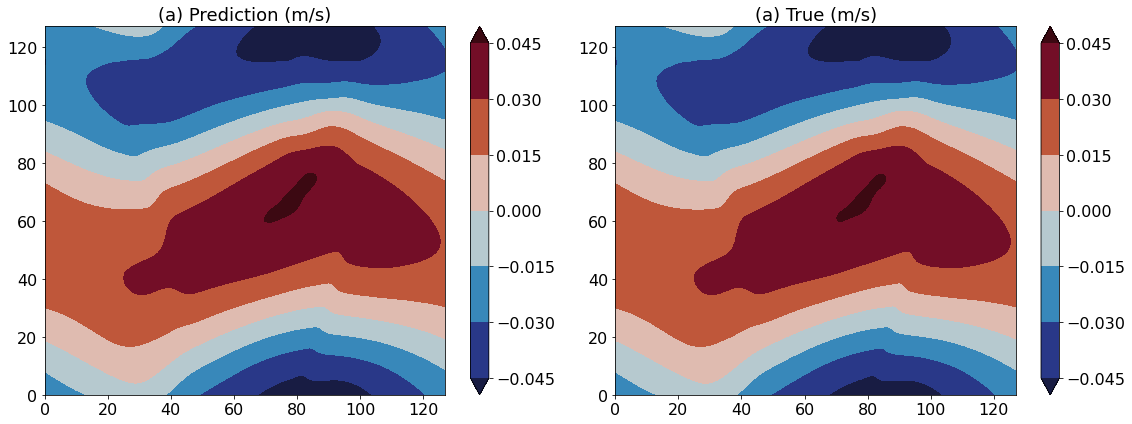

In [59]:
ress = [128]
var = 'xvel'
sr_outs = {}

index = ['(a)','(b)']
cranges = {}
cranges['xvel'] = np.arange(-0.045,0.0451,0.015)
cranges['temp'] = np.arange(270.50,270.901,0.04)

fig, axes = plt.subplots(1,2,figsize=(16,6))
for k,res in enumerate(ress):
    ii = np.arange(res)
    jj = np.arange(res)

    pred = np.load(f"itests/FNO_out_{var}_init2_to_init1.npy")[0,200,0,:,:] 
    aaa  = np.load(f"itests/FNO_out_{var}_init2_to_init1.npy")[1,200,0,:,:]

    a1 = axes[0].contourf(ii,jj,pred,cranges[var],extend='both',cmap=cmo.balance)
    a2 = axes[1].contourf(ii,jj,aaa,cranges[var],extend='both',cmap=cmo.balance)
    axes[0].set_title(f'{index[0]} Prediction (m/s)')
    axes[1].set_title(f'{index[0]} True (m/s)')

    fig.colorbar(a1, ax=axes[0])
    fig.colorbar(a2, ax=axes[1])

plt.tight_layout()
plt.savefig(f'figs/Dinit_{var}.pdf')

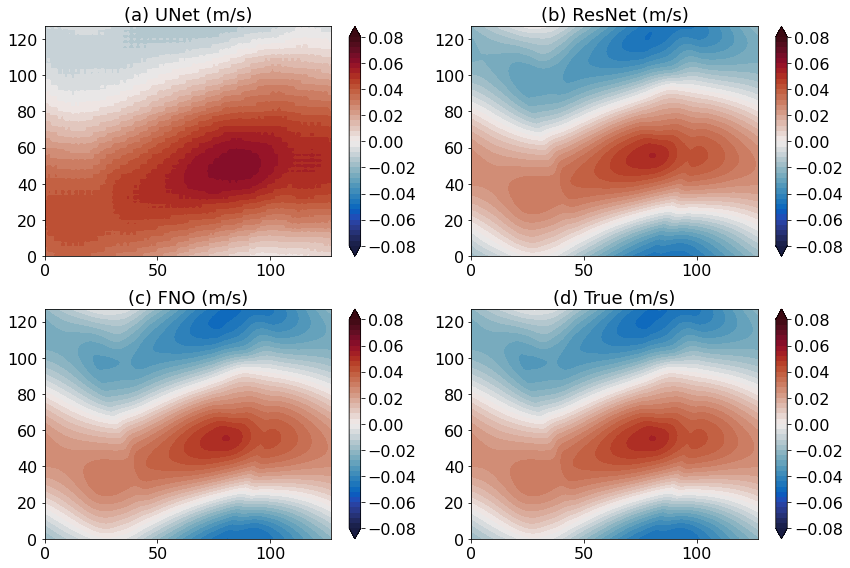

In [17]:
var = 'xvel'
res = 128
index = ['(a)','(b)','(c)','(d)']
cranges = {}
cranges['xvel'] = np.arange(-0.08,0.0801,0.004)
cranges['temp'] = np.arange(270.50,270.901,0.04)
ii = np.arange(res)
jj = np.arange(res)
units = {}
units['temp'] = 'k'
units['xvel'] = 'm/s'
units['num'] = ''

outs = {}
for m in models:
    outs[m] = np.load(f"itests/{m}_out_{var}_init2_to_init1.npy")[0,301,0,:,:]

outs['True'] = np.load(f"itests/FNO_out_{var}_init2_to_init1.npy")[1,301,0,:,:] 

fig, axes = plt.subplots(2,2,figsize=(12,8))

for i,m in enumerate(outs):
    a = axes[i//2][i%2].contourf(ii,jj, outs[m],cranges[var],extend='both',cmap=cmo.balance)
    #a = axes[i//2][i%2].contourf(ii,jj, outs[m],cmap=cmo.balance)
    fig.colorbar(a,ax=axes[i//2][i%2])
    axes[i//2][i%2].set_title(f'{index[i]} {m} ({units[var]})')

#for i,m in enumerate(models):
    
    
plt.tight_layout()
plt.savefig(f'figs/Dinit_{var}.pdf')

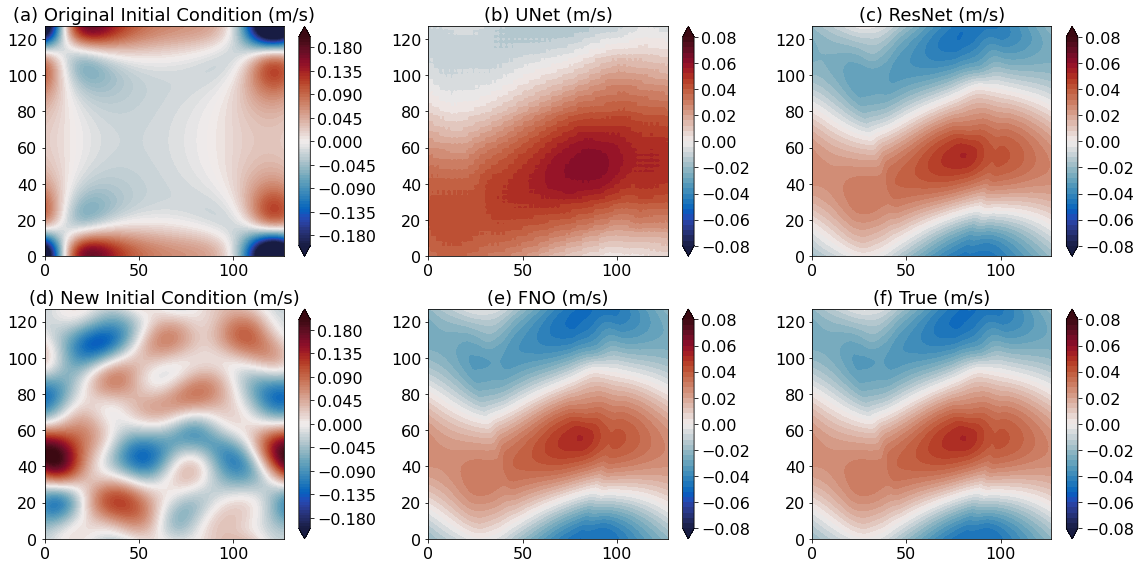

In [94]:
index = ['(b)','(c)','(e)','(f)']
var = 'xvel'
crs = {}
crs['temp'] = np.arange(270.64,270.961,0.002)
crs['xvel'] = np.arange(-0.20,0.201,0.005)


path=f'data/pr-dns/data/out-entrainment2dm_d_0.512_g_{res}_init2/pr_dns_{var}.npy'
data1 = np.load(path)
#data1 = data1.mean(axis=0)
data1 = data1[0,:,:] 

path=f'data/pr-dns/data/out-entrainment2dm_d_0.512_g_{res}_init1/pr_dns_{var}.npy'
data2 = np.load(path)
#data2 = data2.mean(axis=0)
data2 = data2[0,:,:]

fig, axes = plt.subplots(2,3,figsize=(16,8))
a = axes[0][0].contourf(ii,jj,data1,crs[var],extend='both',cmap=cmo.balance)
fig.colorbar(a,ax=axes[0][0])
axes[0][0].set_title(f'(a) Original Initial Condition ({units[var]})')

a = axes[1][0].contourf(ii,jj,data2,crs[var],extend='both',cmap=cmo.balance)
fig.colorbar(a,ax=axes[1][0])
axes[1][0].set_title(f'(d) New Initial Condition ({units[var]})')

outs = {}
for m in models:
    outs[m] = np.load(f"itests/{m}_out_{var}_init2_to_init1.npy")[0,301,0,:,:]

outs['True'] = np.load(f"itests/FNO_out_{var}_init2_to_init1.npy")[1,301,0,:,:] 


for i,m in enumerate(outs):
    a = axes[i//2][i%2+1].contourf(ii,jj, outs[m],cranges[var],extend='both',cmap=cmo.balance)
    #a = axes[i//2][i%2].contourf(ii,jj, outs[m],cmap=cmo.balance)
    fig.colorbar(a,ax=axes[i//2][i%2+1])
    axes[i//2][i%2+1].set_title(f'{index[i]} {m} ({units[var]})')


plt.tight_layout()
plt.savefig(f'figs/Dinit_{var}.pdf')

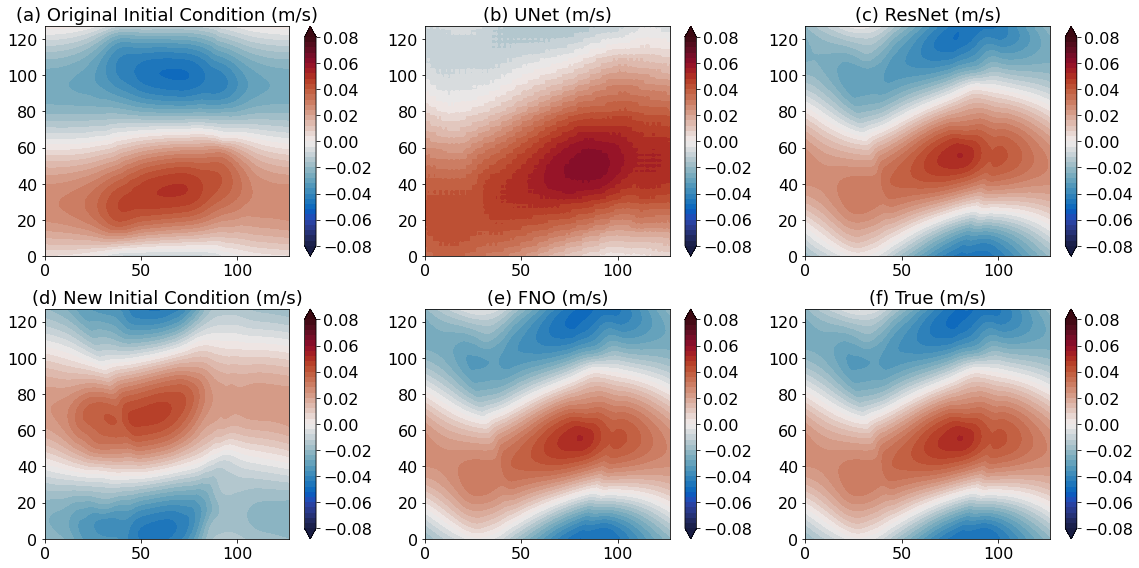

In [110]:
index = ['(b)','(c)','(e)','(f)']
var = 'xvel'
crs = {}
crs['temp'] = np.arange(270.64,270.961,0.002)
crs['xvel'] = np.arange(-0.20,0.201,0.005)


path=f'data/pr-dns/data/out-entrainment2dm_d_0.512_g_{res}_init2/pr_dns_{var}.npy'
data1 = np.load(path)
#data1 = data1.mean(axis=0)
data1 = data1[4302,:,:] 

path=f'data/pr-dns/data/out-entrainment2dm_d_0.512_g_{res}_init1/pr_dns_{var}.npy'
data2 = np.load(path)
#data2 = data2.mean(axis=0)
data2 = data2[4322,:,:]

fig, axes = plt.subplots(2,3,figsize=(16,8))
a = axes[0][0].contourf(ii,jj,data1,cranges[var],extend='both',cmap=cmo.balance)
fig.colorbar(a,ax=axes[0][0])
axes[0][0].set_title(f'(a) Original Initial Condition ({units[var]})')

a = axes[1][0].contourf(ii,jj,data2,cranges[var],extend='both',cmap=cmo.balance)
fig.colorbar(a,ax=axes[1][0])
axes[1][0].set_title(f'(d) New Initial Condition ({units[var]})')

outs = {}
for m in models:
    outs[m] = np.load(f"itests/{m}_out_{var}_init2_to_init1.npy")[0,301,0,:,:]

outs['True'] = np.load(f"itests/FNO_out_{var}_init2_to_init1.npy")[1,301,0,:,:] 


for i,m in enumerate(outs):
    a = axes[i//2][i%2+1].contourf(ii,jj, outs[m],cranges[var],extend='both',cmap=cmo.balance)
    #a = axes[i//2][i%2].contourf(ii,jj, outs[m],cmap=cmo.balance)
    fig.colorbar(a,ax=axes[i//2][i%2+1])
    axes[i//2][i%2+1].set_title(f'{index[i]} {m} ({units[var]})')


plt.tight_layout()
plt.savefig(f'figs/Dinit_{var}.pdf')

## compared different initial condition

(2, 1000, 1, 128, 128)
(2, 1000, 1, 128, 128)


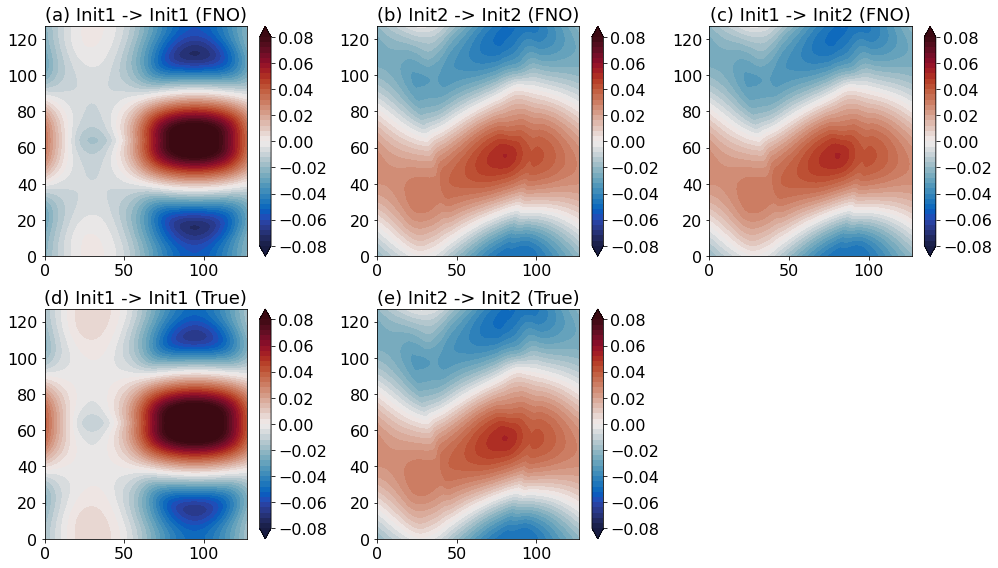

In [293]:
res = 128
ii = np.arange(res)
jj = np.arange(res)
crs = {}
crs['xvel'] = np.arange(-0.08,0.0801,0.004)
diff_crs = np.arange(-0.12,0.12,0.01)
crs['temp'] = np.arange(270.50,270.961,0.05)

fig, axes = plt.subplots(2,3,figsize=(14,8))

method = 'FNO'
var = 'xvel'

itest_path = f'archived/20230410_v1/itests/{method}_out_{var}_init2_to_init1.npy'
test1_path = f'tests/{method}_out_{var}_r_128_init1xxxx.npy'
test2_path = f'archived/20230410_v1/tests/{method}_out_{var}_r_128.npy'

itest = np.load(itest_path)
itest_pred = itest[0,301,0,:,:]
itest_true = itest[1,301,0,:,:]


test1 = np.load(test1_path)
test1_pred = test1[0,301,0,:,:]
test1_true = test1[1,301,0,:,:]
print(test1.shape)

test2 = np.load(test2_path)
test2_pred = test2[0,301,0,:,:]
test2_true = test2[1,301,0,:,:]
print(test2.shape)

#diff = (itest_p - test1_p)/np.mean(np.abs(itest_true))


a = axes[0][1].contourf(ii,jj,test1_pred,crs[var],extend='both',cmap=cmo.balance)
b = axes[0][0].contourf(ii,jj,test2_pred,crs[var],extend='both',cmap=cmo.balance)
c = axes[0][2].contourf(ii,jj,itest_pred,crs[var],extend='both',cmap=cmo.balance)

axes[0][0].set_title('(a) Init1 -> Init1 (FNO)')
axes[0][1].set_title('(b) Init2 -> Init2 (FNO)')
axes[0][2].set_title('(c) Init1 -> Init2 (FNO)')

fig.colorbar(b,ax=axes[0][0])
fig.colorbar(a,ax=axes[0][1])
fig.colorbar(c,ax=axes[0][2])

a = axes[1][1].contourf(ii,jj,test1_true,crs[var],extend='both',cmap=cmo.balance)
b = axes[1][0].contourf(ii,jj,test2_true,crs[var],extend='both',cmap=cmo.balance)
#c = axes[1][2].contourf(ii,jj,itest_true,crs[var],extend='both',cmap=cmo.balance)

axes[1][0].set_title('(d) Init1 -> Init1 (True)')
axes[1][1].set_title('(e) Init2 -> Init2 (True)')
#axes[1][2].set_title('(f) Init1 -> Init2 (True)')



fig.colorbar(a,ax=axes[1][0])
fig.colorbar(b,ax=axes[1][1])
#fig.colorbar(c,ax=axes[1][2])

axes[1][2].axis('off')

plt.tight_layout()
plt.savefig(f'figs/Dinit_{var}.pdf')

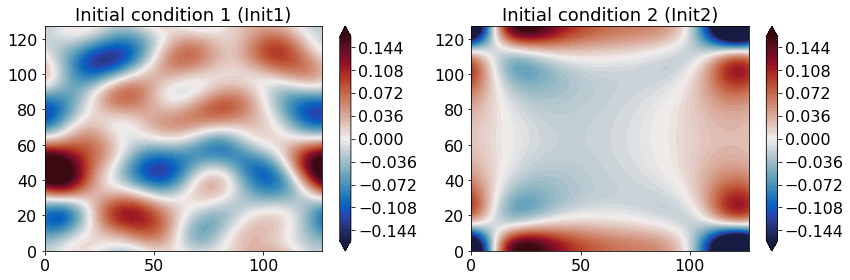

In [318]:
res = 128
ii = np.arange(res)
jj = np.arange(res)
crs = {}
crs['xvel'] = np.arange(-0.16,0.161,0.004)
diff_crs = np.arange(-0.12,0.12,0.01)
crs['temp'] = np.arange(270.50,270.961,0.05)
#fig, axes = plt.subplots(2,3,figsize=(14,8))
inds = ['(a)','b']

fig,axes = plt.subplots(1,2,figsize=(12,4))

varn='xvel'

for initID in [1,2]:
    path_dns = "/home/tzhang/FNO_PR_DNS/data/pr-dns/data/out-entrainment2dm_d_0.512_g_128"
    data_dns = np.load(f'{path_dns}_init{initID}/pr_dns_{varn}.npy')

    a = axes[initID-1].contourf(ii,jj,data_dns[0,:,:],crs[varn],extend='both',cmap=cmo.balance)
    fig.colorbar(a,ax=axes[initID-1])
    axes[initID-1].set_title(f'Initial condition {initID} (Init{initID})')

plt.tight_layout()
plt.savefig('figs/two_inits.pdf')

In [329]:
aa = np.load('itests/FNO_out_temp_init2_to_init1xxxx.npy')
print(aa.shape)

(2, 2000, 1, 128, 128)


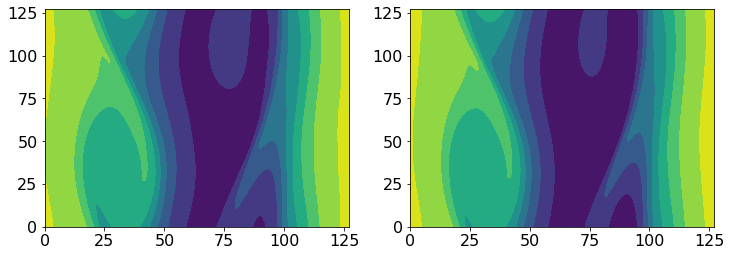

In [330]:
fig,axes = plt.subplots(1,2,figsize=(12,4))

axes[0].contourf(ii,jj,aa[0,200,0,:,:])
axes[1].contourf(ii,jj,aa[1,200,0,:,:])